In [42]:
import sys
import os
import importlib
import pandas as pd
import numpy as np
import geopandas
import seaborn
sys.path.insert(0, os.path.join(os.environ["DESEABEL_PATH"], "ocean_ecosystem"))
import noise_impactor
import simulator
import marine_fauna
import marine_map
import matrix_conversion
importlib.reload(matrix_conversion)
importlib.reload(marine_map)
importlib.reload(marine_fauna)
importlib.reload(simulator)
importlib.reload(noise_impactor)

from noise_impactor import FishingBoat, PileDriving
from simulator import Simulator
from marine_fauna import Fish
from marine_map import MarineMap
from matrix_conversion import *

## Create 3 boats and one fish species

In [43]:
boat1 = FishingBoat(lat=45.20, lon=-5.2, speed=10, length=10)
boat2 = FishingBoat(lat=44.85, lon=-4.9, speed=15, length=13)
boat3 = FishingBoat(lat=44.5, lon=-5.2, speed=17, length=5)

fish = Fish("../../data/fish.geojson")

## Initialize a marine map with specific shapes

In [44]:
# Example
width = 300000
height = 300000
step = 1000
longitude_west = -2.40953
latitude_north = 46.41813
longitude_west = -6.40953
latitude_north = 46.41813

marine_map = MarineMap(width, height, step, longitude_west, latitude_north)

## Initialize a Simulator

In [45]:
simu = Simulator(marine_map, list_noise_impactor=[boat1, boat2], list_marine_fauna=[])

# Add manually other objects
simu.add_noise_impactor(boat3)
simu.add_marine_fauna(fish)

#### Plot the heatmap of the noise from the map

<AxesSubplot: >

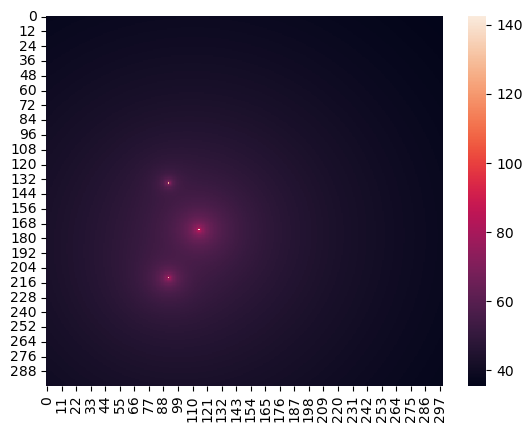

In [46]:
marine_map.matrix_decibel_gpd.to_file("../data/matrix_decibel.geojson", driver="GeoJSON")
seaborn.heatmap(marine_map.matrix_decibel)

## Compute the marine fauna impact for the fish species

In [47]:
simu.update_marine_fauna_impact("fish")

#### Show different results
1. Plot the corresponding quantified matrix of the different levels of noise impacts
2. Print the corresponding array impact
3. Plot The corresponding location of the fish species

In [ ]:
marine_map.matrix_decibel_impact_quantified_gpd.to_file("../data/matrix_decibel_impact_quantified", driver="GeoJSON")
seaborn.heatmap(marine_map.matrix_decibel_impact_quantified)

In [ ]:
with open(f"../data/array_impact_{fish.type}.json", "w") as f_out:
    json.dump({i: impact for i, impact in enumerate(fish.array_impact)}, f_out)
fish.array_impact

In [ ]:
coords = marine_map.get_coords_xy_from_geopandas(fish.spot_gpd)
matrix_res = np.zeros(marine_map.matrix_decibel.shape)

matrix_res[coords[:, 0], coords[:, 1]] = 1

seaborn.heatmap(matrix_res)